#### 1. 관서명, 살인발생, ... <= 컬럼명

  | 관서명 | 살인발생 | 살인검거 |
  | ------ | ------| ------ |
  | 중부  |    2 |  2   |
 
#### 2. 관서명(구분)이 인덱스, 살인발생, ... 컬럼명 

       |살인발생|살인검거|
       | ------| ------ |
       |    2   |  2     |

In [3]:
# 위의 형태로 DateFrame이 나오겟끔 2017년.csv을 읽어서 위의 형태로 구성하시오
import pandas as pd
import numpy as np

In [4]:
# 한글명 제거후 로드
#pd.read_csv('../data/seoul_crime/2017.csv', encoding='euc-kr')
# engine 옵션이 c, python으로 나눠져서 파싱을 하게 되는데 
# 기본값이 c엔진이라 한글이 깨짖는 경향이 있음, python 엔진으로 설정하면 
# 파일명 및 파일 내용의 인코딩까지 자동 처리함
crime_raw_data = pd.read_csv('../data/seoul_crime/2017년.csv', engine='python')
crime_raw_data.shape

(310, 4)

In [5]:
# 5대범죄 * 2(발생, 검거) => 관할서당 데이터는 10개
# 총관할서의 수 = crime_raw_data.shape[0] / 10 => 31
crime_raw_data.shape[0] / 10

31.0

In [6]:
# 따라서 우리하는 구조의 데이터수는 
# (31, 10) 이런형태로 나오면 OK
tmp = pd.pivot_table( crime_raw_data, 
                index=['구분'], # 구분이 관할서이다.
                columns=['죄종','발생검거']
              )
tmp.shape

(31, 10)

In [7]:
tmp.head(2)

건수                                          
죄종     강간       강도     살인      절도          폭력      
발생검거   검거   발생  검거  발생 검거 발생   검거    발생    검거    발생
구분                                                 
강남    366  456  16  13  6  6  787  2069  1942  2229
강동    169  172  12  10  6  5  949  1645  2109  2429

In [8]:
tmp.columns

MultiIndex(levels=[['건수'], ['강간', '강도', '살인', '절도', '폭력'], ['검거', '발생']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=[None, '죄종', '발생검거'])

In [9]:
tmp.columns.levels[0]

Index(['건수'], dtype='object')

In [10]:
tmp.columns.levels[1]

Index(['강간', '강도', '살인', '절도', '폭력'], dtype='object', name='죄종')

In [11]:
tmp.columns.levels[2]

Index(['검거', '발생'], dtype='object', name='발생검거')

In [12]:
# 새로 규정된 컬럼명 생성
new_cols = [   fStr + bStr
    for fStr in tmp.columns.levels[1]
    for bStr in tmp.columns.levels[2] ] 
new_cols

['강간검거',
 '강간발생',
 '강도검거',
 '강도발생',
 '살인검거',
 '살인발생',
 '절도검거',
 '절도발생',
 '폭력검거',
 '폭력발생']

In [13]:
# 전체 컬럼명을 변경하는 방법을 덮어버려라 (순서주의)
tmp.columns = new_cols

In [14]:
tmp.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구분,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229
강동,169,172,12,10,6,5,949,1645,2109,2429


In [15]:
crime_data = tmp[:]

In [16]:
crime_data.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구분,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229
강동,169,172,12,10,6,5,949,1645,2109,2429


In [17]:
import urllib.request
import json

In [18]:
# 관할서 이름 => 풀네이밍 구성, 강남 => 서울강남경찰서
# 서울강남경찰서 => gps 획득 => kakapapi 활용
# 서울강남경찰서 => address => 자치구 정보 획득 (1개 관할서는 보정)
# 구분
API_KEY = 'e34bb81e2e35e85ca6efee410badd670'
url     = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'
# 데이터를 담아둘 리스트
ys            = list()
xs            = list()
address_names = list()
for policeName in crime_data.index:
    policeName = '서울%s경찰서' %  policeName
    print( policeName )
    '''
    GET /v2/local/search/keyword.{format} HTTP/1.1
    Host: dapi.kakao.com
    Authorization: KakaoAK {app_key}
    '''
    # URL 문자열 생성
    tmp_url = url.format( urllib.parse.quote(policeName) )
    print(tmp_url)
    # 요청객체 생성완료
    request = urllib.request.Request( tmp_url )
    # API 키설정
    request.add_header("Authorization", 'KakaoAK {app_key}'.format(app_key=API_KEY) )
    # 통신 요청
    response = urllib.request.urlopen(request)
    # 응답이 성공이면
    if(response.getcode()==200):
        # 응답 결과를 접근 가능하게 로드
        tmp = json.load(response)
        # 위도 : y, 경도 : x, 주소 : address_name 값을 추출하시오
        y = tmp['documents'][0]['y']
        x = tmp['documents'][0]['x']
        address_name = tmp['documents'][0]['address_name']
        print( y, x, address_name )
        # 위의 추츨한 값을 리스트에 각각 담으시오
        ys.append( y )
        xs.append( x )
        address_names.append( address_name )
    else:
        pass

서울강남경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%82%A8%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5093899463715 127.067070541137 서울 강남구 대치동 998
서울강동경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%8F%99%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5286763457485 127.126894359114 서울 강동구 성내동 541-1
서울강북경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%B6%81%EA%B2%BD%EC%B0%B0%EC%84%9C
37.637408362838 127.027340967017 서울 강북구 번동 415-15
서울강서경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EC%84%9C%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5397837301896 126.829985881518 서울 양천구 신월동 25
서울관악경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B4%80%EC%95%85%EA%B2%BD%EC%B0%B0%EC%84%9C
37.4745875338795 126.951062346192 서울 관악구 봉천동 1695-5
서울광진경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B4%91%EC%A7%

In [19]:
len(xs), len(ys), len(address_names)

(31, 31, 31)

In [20]:
crime_data['위도'] = ys
crime_data['경도'] = xs
crime_data['주소'] = address_names

In [21]:
crime_data.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소
구분,,,,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229,37.5093899463715,127.067070541137,서울 강남구 대치동 998
강동,169,172,12,10,6,5,949,1645,2109,2429,37.5286763457485,127.126894359114,서울 강동구 성내동 541-1


In [22]:
# 주소 데이터로부터 자치구 정보를 추출하여 자치구 컬럼을 추가하시오
for addr in crime_data['주소']:
    print( addr.split()[1] ) # split의 인자는 구분자다(안 넣으면 공백이 구분자다)

강남구
강동구
강북구
양천구
관악구
광진구
구로구
금천구
중구
노원구
도봉구
동대문구
동작구
마포구
서초구
서대문구
은평구
서초구
성동구
성북구
송파구
강남구
양천구
영등포구
용산구
은평구
종로구
성북구
중랑구
중구
종로구


In [23]:
# python의 방식으로 작성됨
crime_data['자치구'] =  [ addr.split()[1] for addr in crime_data['주소'] ]

In [24]:
# 1-1. pandas apply랑 소스코드가 동일하다고 생각하면 된다
def mod(x):
    return x.split()[1] 

In [25]:
# 1-2. pandas의 방식으로 추가해보시오 -> apply() 사용
crime_data['자치구2'] = crime_data['주소'].apply( lambda x: x.split()[1] )  # apply: 한놈씩 끄집어내서 작성한다

In [26]:
crime_data['자치구3'] = crime_data['주소'].apply( mod )

In [27]:
del crime_data['자치구2']
del crime_data['자치구3']

In [28]:
crime_data.iloc[:,[12,13]]

,주소,자치구
구분,,
강남,서울 강남구 대치동 998,강남구
강동,서울 강동구 성내동 541-1,강동구
강북,서울 강북구 번동 415-15,강북구
강서,서울 양천구 신월동 25,양천구
관악,서울 관악구 봉천동 1695-5,관악구
광진,서울 광진구 구의동 254-32,광진구
구로,서울 구로구 구로동 436,구로구
금천,서울 금천구 시흥동 산 189,금천구
남대문,서울 중구 남대문로5가 561,중구


In [29]:
# 자치구의 값을 조사하여 중복되지 않는 개수가 25인지 확인!!!
len(crime_data['자치구'].unique()), crime_data['자치구'].unique() # 결과는 list이고 len으로 확인을 해봄)

(24, array(['강남구', '강동구', '강북구', '양천구', '관악구', '광진구', '구로구', '금천구', '중구',
        '노원구', '도봉구', '동대문구', '동작구', '마포구', '서초구', '서대문구', '은평구', '성동구',
        '성북구', '송파구', '영등포구', '용산구', '종로구', '중랑구'], dtype=object))

In [30]:
# 구분값이 강서인 데이터의 자치구의 값을 양천구에서 강서구로 변경
# crime_data.rename( columns[2]={ crime_data.index[3]:'강서구'}, inplace=True ) -> 내가 작성한 것.(가동안되는 소스 코드)
# 문법적인 부분은 pandas basic에서 다룬 내용이다
# crime_data.loc[ ['강서'], ['자치구'] ]
# crime_data.loc[ ['강서'],['자치구'] ] = '강서구'
crime_data.loc[ '강서','자치구' ] = '강서구'
crime_data

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소,자치구
구분,,,,,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229,37.5093899463715,127.067070541137,서울 강남구 대치동 998,강남구
강동,169,172,12,10,6,5,949,1645,2109,2429,37.5286763457485,127.126894359114,서울 강동구 성내동 541-1,강동구
강북,153,208,5,7,8,8,635,1014,2023,2156,37.637408362838,127.027340967017,서울 강북구 번동 415-15,강북구
강서,253,316,6,4,11,11,1113,1888,2544,2916,37.5397837301896,126.829985881518,서울 양천구 신월동 25,강서구
관악,323,379,6,7,7,8,1152,1979,2666,3152,37.4745875338795,126.951062346192,서울 관악구 봉천동 1695-5,관악구
광진,208,261,8,13,5,6,1168,2220,1900,2146,37.5428136101647,127.083842771963,서울 광진구 구의동 254-32,광진구
구로,181,328,6,8,8,7,869,1725,2344,2827,37.4948844667899,126.886660285169,서울 구로구 구로동 436,구로구
금천,212,240,5,5,5,5,674,1141,1676,1874,37.45725314643252,126.89674921449215,서울 금천구 시흥동 산 189,금천구
남대문,62,94,3,3,0,1,400,785,780,863,37.5549786547527,126.973499492486,서울 중구 남대문로5가 561,중구


In [31]:
crime_data.shape

(31, 14)

In [32]:
# 현재까지 데이터를 덤프친다.(백업한다)
crime_data.to_csv('../data/crime_data_gps_addr.csv', sep=',', encoding='utf-8')

In [33]:
# 덤프친 데이터를 불러와서 작업한다는 생각으로 한다 -> 데이터를 불러왔을 경우 구조가 바뀔수 있다 (구분이 컬럼으로 바뀌면서 0,1,2,3,4,..됨)
crime_anal_raw = pd.read_csv('../data/crime_data_gps_addr.csv', encoding='utf-8' )
crime_anal_raw.head(2)

,구분,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소,자치구
0,강남,366,456,16,13,6,6,787,2069,1942,2229,37.509390,127.067071,서울 강남구 대치동 998,강남구
1,강동,169,172,12,10,6,5,949,1645,2109,2429,37.528676,127.126894,서울 강동구 성내동 541-1,강동구


In [34]:
# crime_data -> 자치구별로 통합 -> 데이터는 25개로 자치구기준으로 구성하라
# pivot으로 작성해야만 한다
# 자치구내에 경찰서가 2개인 자치구는 합산으로 수치를 맞춘다( 검거와 발생으로)


#crime_anal = pd.pivot_table( crime_data,
#                             index='자치구', # 이 까지의 결과는 부동소수로 나온다
#                             aggfunc=np.sum  # aggfunc 으로 합산으로 해서 정수값으로 바꿔준다
#                           )
# 아웃풋에서 차이가 난다
crime_anal = pd.pivot_table( crime_anal_raw, index='자치구', aggfunc=np.sum )
try:
    del crime_anal['위도']
    del crime_anal['경도']
except Exception as e:pass

crime_anal

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
자치구,,,,,,,,,,
강남구,496,607,24,20,7,7,1383,3130,3411,3956
강동구,169,172,12,10,6,5,949,1645,2109,2429
강북구,153,208,5,7,8,8,635,1014,2023,2156
강서구,253,316,6,4,11,11,1113,1888,2544,2916
관악구,323,379,6,7,7,8,1152,1979,2666,3152
광진구,208,261,8,13,5,6,1168,2220,1900,2146
구로구,181,328,6,8,8,7,869,1725,2344,2827
금천구,212,240,5,5,5,5,674,1141,1676,1874
노원구,155,180,7,9,4,4,757,1538,2124,2478


In [35]:
# 컬럼명중에서 검거가 들어간 컬러만 뽑는다
list(filter( lambda x: x.find('검거')>0 , crime_anal.columns ))  # x : 컬럼수가 한놈한놈씩 들어오는것이다

['강간검거', '강도검거', '살인검거', '절도검거', '폭력검거']

In [36]:
# 컬럼명중에서 발생이 들어간 컬러만 뽑는다
list(filter( lambda x: x.find('발생')>0 , crime_anal.columns ))

['강간발생', '강도발생', '살인발생', '절도발생', '폭력발생']

In [37]:
# 
'강도검거'.find('검거')

2

In [38]:
# 검거율 정보생성시 오차가 존재한다 -> 검거발생시 작년에 검거한 발생율이 이월되서 수치는 정확하지는 않음
# 검거율 정보를 생성 : 강도검거율 = 강도검거/강도발생 * 100  -> 총 5개를 생성
# 강도검거.....모두 삭제
target = list(filter( lambda x: x.find('검거')>0 , crime_anal.columns ))

crime_anal['강간검거율']=crime_anal['강간검거']/crime_anal['강간발생'] * 100
crime_anal['강도검거율']=crime_anal['강도검거']/crime_anal['강도발생'] * 100
crime_anal['살인검거율']=crime_anal['살인검거']/crime_anal['살인발생'] * 100
crime_anal['절도검거율']=crime_anal['절도검거']/crime_anal['절도발생'] * 100
crime_anal['폭력검거율']=crime_anal['폭력검거']/crime_anal['폭력발생'] * 100

for col in target:
    del crime_anal[col]

In [39]:
crime_anal.head(2)

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,120.0,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,120.0,120.0,57.689970,86.825854


In [40]:
# xx검거율이 100이상인 것들은 이상치에 해당되므로 일괄적으로 100으로 통일하겠다( 일단 다 100으로 한다 )
col_list = crime_anal.columns[-5:]
col_list

Index(['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율'], dtype='object')

In [41]:
# loc 은 뒤에 1차 찍고 2차 찍는다
for col in col_list:
    crime_anal.loc[ crime_anal[col] > 100, col ] = 100.0 # 1차 : 어떤 데이터, 2차 : 어떤 컬럼을 뺄건지 작성하고 거기다가 100으로 넣어버린것

In [42]:
crime_anal.head(4)

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,100.000000,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,100.000000,100.0,57.689970,86.825854
강북구,208,7,8,1014,2156,73.557692,71.428571,100.0,62.623274,93.831169
강서구,316,4,11,1888,2916,80.063291,100.000000,100.0,58.951271,87.242798


In [43]:
crime_anal['강도검거율'] > 100

자치구
강남구     False
강동구     False
강북구     False
강서구     False
관악구     False
광진구     False
구로구     False
금천구     False
노원구     False
도봉구     False
동대문구    False
동작구     False
마포구     False
서대문구    False
서초구     False
성동구     False
성북구     False
송파구     False
양천구     False
영등포구    False
용산구     False
은평구     False
종로구     False
중구      False
중랑구     False
Name: 강도검거율, dtype: bool

In [44]:
crime_anal.loc[  crime_anal['강도검거율'] == 100, '강도검거율' ]

자치구
강남구     100.0
강동구     100.0
강서구     100.0
금천구     100.0
도봉구     100.0
동대문구    100.0
동작구     100.0
마포구     100.0
서대문구    100.0
성동구     100.0
성북구     100.0
송파구     100.0
영등포구    100.0
은평구     100.0
중구      100.0
중랑구     100.0
Name: 강도검거율, dtype: float64

In [45]:
# 컬럼명은 언제든 변경 가능: 강도발생 -> 강도, 5세트 조정
dic = {
    '강간발생':'강간',
    '강도발생':'강도',
    '살인발생':'살인',
    '절도발생':'절도',
    '폭력발생':'폭력'
}
crime_anal.rename( columns=dic, inplace=True)

In [46]:
crime_anal.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,100.0,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,100.0,100.0,57.689970,86.825854


In [47]:
# 정규화 !! nomarize
# 절도나 폭력은 4자리수 하지만, 강도나 살인은 2자치수이다 . 편차가 너무 크다
# 숫자의 범위를 비슷한 범위내에 두고 비교하는것이 편하고, 합리적이다
# 0 ~ 1 사이로 값을 배치하여 종합적으로 비교

In [48]:
# 머신러닝 모듈 scikit-learn(싸이킷런)의 비지도 학습 (머신러닝은 지도학습과 비지도학습이 있다.)
# 최대, 최소 전처리기를 이용하여 처리 
from sklearn import preprocessing

In [49]:
cols = crime_anal.columns[:5]
cols

Index(['강간', '강도', '살인', '절도', '폭력'], dtype='object')

In [50]:
# 데이터를 획득 : DataFrame에서 데이터만 추출 => numpy의 배열로 리턴
x = crime_anal[ cols ].values # 데이터프레임에서 값만 뽑는다 (values)
x.shape, x.dtype

((25, 5), dtype('int64'))

In [51]:
# 전처리기 획득
min_max_scaler = preprocessing.MinMaxScaler()

In [52]:
# 전처리 => 정규화로 ( 입력원이 부동소수이여야 한다 )
x_scaled = min_max_scaler.fit_transform( x.astype(float) )

In [53]:
x_scaled

array([[1.        , 1.        , 0.42857143, 1.        , 1.        ],
       [0.13518887, 0.47368421, 0.28571429, 0.40528634, 0.4340252 ],
       [0.20675944, 0.31578947, 0.5       , 0.1525831 , 0.33283914],
       [0.42147117, 0.15789474, 0.71428571, 0.50260312, 0.61452928],
       [0.54671968, 0.31578947, 0.5       , 0.53904686, 0.70200148],
       [0.31212724, 0.63157895, 0.35714286, 0.63556268, 0.32913269],
       [0.44532803, 0.36842105, 0.42857143, 0.43732479, 0.58154188],
       [0.27037773, 0.21052632, 0.28571429, 0.20344413, 0.22831727],
       [0.15109344, 0.42105263, 0.21428571, 0.36243492, 0.45218681],
       [0.        , 0.10526316, 0.        , 0.        , 0.        ],
       [0.12127237, 0.10526316, 0.71428571, 0.36603925, 0.36730912],
       [0.5805169 , 0.31578947, 0.        , 0.23748498, 0.16382506],
       [0.78727634, 0.36842105, 0.14285714, 0.58510212, 0.52446256],
       [0.19483101, 0.        , 0.21428571, 0.2390869 , 0.15492958],
       [0.72763419, 0.63157895, 0.

In [54]:
# 데이터프레임 재구성
crime_anal_norm = pd.DataFrame( x_scaled, columns=cols, index=crime_anal.index)
crime_anal_norm.head(2) # 출력결과는 검거율이 제외되서 추출된다.

,강간,강도,살인,절도,폭력
자치구,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000
강동구,0.135189,0.473684,0.285714,0.405286,0.434025


In [55]:
# 누락된 검거율 컬럼목록
col_list

Index(['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율'], dtype='object')

In [56]:
# 검거율 5개를 동시 추가
crime_anal_norm[ col_list ] = crime_anal[col_list]

In [57]:
crime_anal_norm.shape

(25, 10)

In [58]:
crime_anal_norm.head(2) # 위 쪽 crime_anal_norm의 누락된 리스트를 추가시킨 결과이다.

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.0,100.0,44.185304,86.223458
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.0,100.0,57.689970,86.825854


In [59]:
# 1차 분석( cctv 인구수 ) 관련 데이터 로드
# 데이터를 df로 구성시 인덱스 직접 지정
result_CCTV = pd.read_csv('../data/populate_per_cctv_analysis_result.csv', encoding='utf-8',
                          index_col='자치구'# index_col='자치구:자치구가 index로 들어간다
                         )
result_CCTV.shape

(25, 15)

In [60]:
result_CCTV.columns

Index(['소계', '2014년도 이전', '2015년', '2016년', '2017년', '2018년', '최신 증가율', '인구수',
       '한국인', '외국인', '고령자', '외국인비율', '고령자비율', 'CCTV비율', '오차'],
      dtype='object')

In [61]:
# crime_anal_norm과 result_CCTV의 25가 같은 수 이므로 병합을 진행할 수 있다

In [62]:
# 병합
# 필요한것만 컬럼을 추가하겠다( 추가 대상의 컬럼명은 자유롭게 변경가능 )
crime_anal_norm[ ['인구수','CCTV'] ] = result_CCTV[ ['인구수','소계'] ] # *변경할 컬럼명 = 기존의 컬럼명
crime_anal_norm.shape, crime_anal_norm.columns

((25, 12),
 Index(['강간', '강도', '살인', '절도', '폭력', '강간검거율', '강도검거율', '살인검거율', '절도검거율',
        '폭력검거율', '인구수', 'CCTV'],
       dtype='object'))

In [63]:
# 발생건수를 다합치면 => 범죄라고 표현할 수 있다
cols = crime_anal_norm.columns[:5] # 5개의 컬럼을 집어넣는다
# crime_anal_norm[ cols ] # 5개의 컬럼에 대한 값이 나온다
np.sum( crime_anal_norm[ cols ], axis=1 ) # 0: 서울시전체의 범죄힙산, 1: 자치구별 범죄합산

자치구
강남구     4.428571
강동구     1.733899
강북구     1.507971
강서구     2.410784
관악구     2.603557
광진구     2.265544
구로구     2.261187
금천구     1.198380
노원구     1.601054
도봉구     0.105263
동대문구    1.674170
동작구     1.297616
마포구     2.408119
서대문구    0.803133
서초구     2.827567
성동구     0.448304
성북구     1.457606
송파구     2.028395
양천구     1.028849
영등포구    3.293628
용산구     1.355643
은평구     1.437401
종로구     1.931385
중구      1.528519
중랑구     1.479631
dtype: float64

In [64]:
crime_anal_norm['범죄'] = np.sum( crime_anal_norm[ cols ], axis=1 )
crime_anal_norm.iloc[ :, [ len(crime_anal_norm.columns)-1 ] ] # 0 ~ 5 사이의 정규화된 범죄율

,범죄
자치구,
강남구,4.428571
강동구,1.733899
강북구,1.507971
강서구,2.410784
관악구,2.603557
광진구,2.265544
구로구,2.261187
금천구,1.198380
노원구,1.601054


In [65]:
# 검거 항목을 생성하시오 (방식은 범죄와 동일하다)
cols = ['강간검거율', '강도검거율', '살인검거율', '절도검거율',
        '폭력검거율']
crime_anal_norm['검거'] = np.sum( crime_anal_norm[ cols ], axis=1 )
crime_anal_norm.iloc[ :, [ len(crime_anal_norm.columns)-1 ] ]

,검거
자치구,
강남구,412.122106
강동구,442.771638
강북구,401.440707
강서구,426.257361
관악구,401.230996
광진구,365.714707
구로구,363.474489
금천구,436.838689
노원구,398.822941


In [66]:
crime_anal_norm.shape

(25, 14)

In [67]:
crime_anal_norm

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.000000,100.000000,44.185304,86.223458,547453,5221,4.428571,412.122106
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.000000,100.000000,57.689970,86.825854,431920,1879,1.733899,442.771638
강북구,0.206759,0.315789,0.500000,0.152583,0.332839,73.557692,71.428571,100.000000,62.623274,93.831169,322915,1265,1.507971,401.440707
강서구,0.421471,0.157895,0.714286,0.502603,0.614529,80.063291,100.000000,100.000000,58.951271,87.242798,603611,1617,2.410784,426.257361
관악구,0.546720,0.315789,0.500000,0.539047,0.702001,85.224274,85.714286,87.500000,58.211218,84.581218,520040,3985,2.603557,401.230996
광진구,0.312127,0.631579,0.357143,0.635563,0.329133,79.693487,61.538462,83.333333,52.612613,88.536813,371063,1581,2.265544,365.714707
구로구,0.445328,0.368421,0.428571,0.437325,0.581542,55.182927,75.000000,100.000000,50.376812,82.914751,438486,3227,2.261187,363.474489
금천구,0.270378,0.210526,0.285714,0.203444,0.228317,88.333333,100.000000,100.000000,59.070990,89.434365,254021,1634,1.198380,436.838689
노원구,0.151093,0.421053,0.214286,0.362435,0.452187,86.111111,77.777778,100.000000,49.219766,85.714286,548160,1906,1.601054,398.822941


## 보다 향상된 시각화 도구 [seaborn:씨본]
- 베이직 폴더로 이동( seaborn_basic 파일 생성)
- korea_font.py파일을 복사해서 basic폴더안에서 붙여넣기 -> seborn파일 작성 시작
- basic폴더의 시각화 파일 오픈 (내용 확인용)

<a href='http://localhost:8888/notebooks/Desktop/py_projects/analysis/pandas/basic/seaborn_basic.ipynb'>seaborn 기초학습</a>

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


In [70]:
crime_anal_norm.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.0,100.0,44.185304,86.223458,547453,5221,4.428571,412.122106
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.0,100.0,57.689970,86.825854,431920,1879,1.733899,442.771638


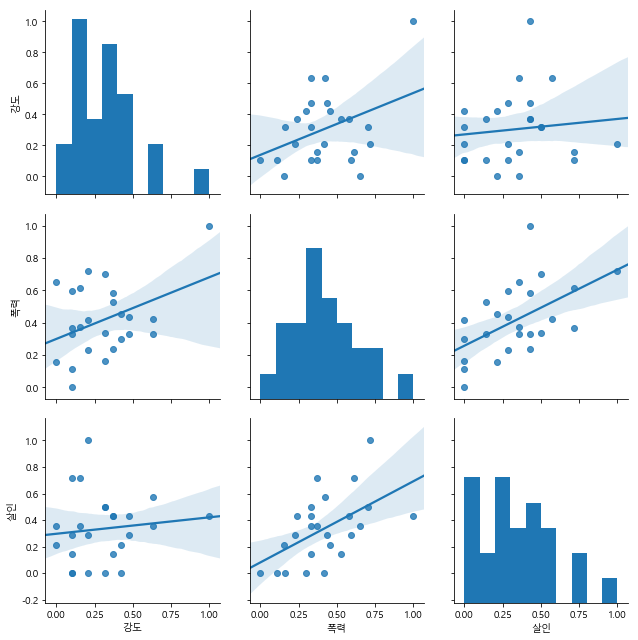

In [71]:
# 변수간의 상관성을 먼저 확인한다 => 산포행렬 
# 범죄들간의 연관성을 찾기 위해서
# kind='reg' : 선형회귀
sns.pairplot( crime_anal_norm, vars=[ '강도', '폭력', '살인' ], size=3, kind='reg' ) # reg : 선긋기
plt.show()
# 바운더리가 얇게 나오는곳이 오차가 작은곳이다(그나마 정확하다는 것)
# 폭력과 살인은 연관성이 깊다 -> 폭력이 많아질수록 살인유로 높아진다
# 강도와 살인은 그 연관성이 별로 느슨하다

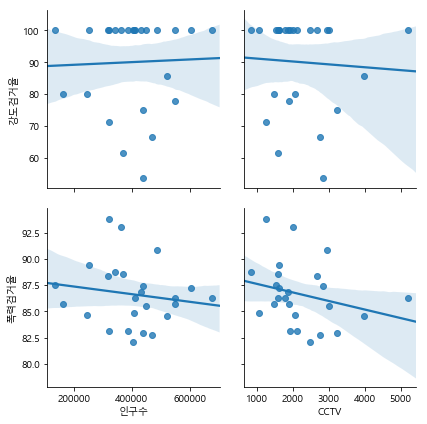

In [72]:
# 위의 연관성 말고도, 
# X : 인구수, CCTV,, Y : 강도검거율, 폭력검거율 을 표현해줄 것이다
sns.pairplot( crime_anal_norm, x_vars=['인구수','CCTV'], y_vars=['강도검거율','폭력검거율'], size=3, kind='reg' )
plt.show()
# 기울기가 내려가는 경우 0으로 가까워질수록 연관이 없다, 1로 가까워질수록 연관성이 높아진다
# 이 시각화의 결과 : 인구수와 CCTV수는 검거율과 관련이 없다!!
# 원 CCTV의 목적은 예방에 촛점이 맞춰져 있고, 검거 자체는 인구와 상관없는 요인들의 영향을 받는다

In [73]:
# 검거건을 합산한것이니 500이 최대치다
# 검거항목의 최대값(최고값)을 100으로 한정하고, 그 기준으로 값을 배치
# 정규화 여기서 완성됨 => 값을 동일 범위내로 배치
crime_anal_norm['검거'] = crime_anal_norm['검거'] / crime_anal_norm['검거'].max() * 100

In [74]:
crime_anal_norm['검거']

자치구
강남구      90.658174
강동구      97.400425
강북구      88.308492
강서구      93.767633
관악구      88.262360
광진구      80.449525
구로구      79.956724
금천구      96.095302
노원구      87.732638
도봉구     100.000000
동대문구     96.794209
동작구      83.216010
마포구      89.949141
서대문구     94.849146
서초구      76.459876
성동구      92.247281
성북구      91.358285
송파구      91.374543
양천구      77.445992
영등포구     82.610569
용산구      87.894267
은평구      99.170251
종로구      76.014441
중구       64.122479
중랑구      92.751632
Name: 검거, dtype: float64

In [75]:
crime_anal_norm_sort = crime_anal_norm.sort_values( by='검거', ascending=False )
crime_anal_norm_sort.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
도봉구,0.000000,0.105263,0.000000,0.000000,0.000000,100.000000,100.0,100.0,65.876777,88.712242,341649,858,0.105263,100.000000
은평구,0.250497,0.157895,0.357143,0.301962,0.369904,92.608696,100.0,100.0,67.339582,90.868794,487666,2962,1.437401,99.170251


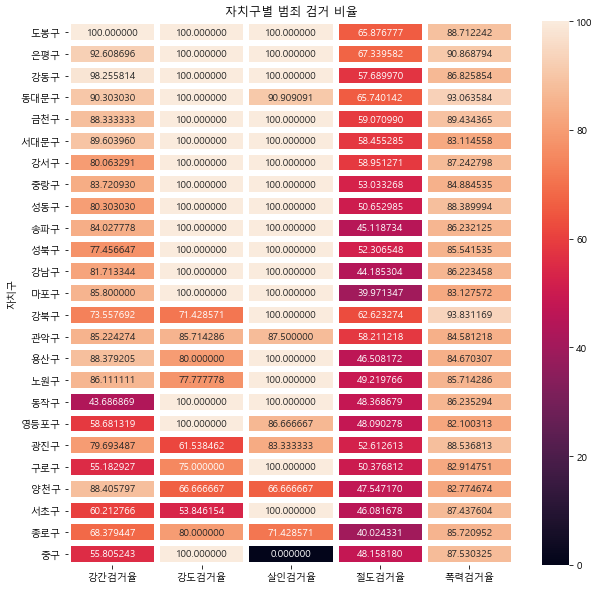

In [76]:
# 히트맵을 통해서 검거율을 보여주겠다
# y축 : 자치구, x축 : xx검거율
# crime_anal_norm_sort를 데이터로 사용하겠다
plt.figure( figsize=( 10, 10 ) )
sns.heatmap( crime_anal_norm_sort[ cols ], annot=True, fmt='f', linewidths=5 ) # linewidths : 데이터들 간의 빈공란이 생긴다
plt.title('자치구별 범죄 검거 비율')
plt.show()


In [77]:
# 범죄 발생 통계
# y축 : 자치구(범죄비율이 높은수), x축 : 5대 범죄 
# heatmap으로 표현해라 

### 지도 시각화(공간 시각화의 한범주)

- folium을 이용하고, geoJson데이터를 이용하여 지도상에 행정구역을 표현
- 구역별 정보를 시각화 한다 
- 연습 : 미국 지도에 실업율 데이터를 가지고 확인
- 적용 : 서울시 지도에 경찰서 표시, 검거율, 발생율에 따른 행정구역의 칼라맵을 적용. 마커를 통해 포인트 설정 및 폴리곤표현으로 검거율은 표시
- 응용 : 주유소정보데이터 부산시 행정구역으로 표현, 자치구별 가장 저렴한 주유소 마킹, 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시.
         브랜드별(6개) 알뜰주유소 -> 브랜드 대비, 진짜 싼지 체크!!

In [78]:
# 서울을 행정구역은 나눠서 드로잉 -> 자치구별로 드로잉
import json
import folium
import pandas as pd

In [79]:
# 한글 경우 인코딩 처리해서 지도에 데이터로 삽입
geo_str = json.load( open( '../data/seoul.json', encoding='utf-8' ) )

In [80]:
crime_anal_norm.columns

Index(['강간', '강도', '살인', '절도', '폭력', '강간검거율', '강도검거율', '살인검거율', '절도검거율',
       '폭력검거율', '인구수', 'CCTV', '범죄', '검거'],
      dtype='object')

In [81]:
gps=[37.5277265,126.9835929]

In [82]:
map_seoul = folium.Map( location=gps, zoom_start=11 )
map_seoul.choropleth( geo_data = geo_str
                 , data=crime_anal_norm
                 , columns=[crime_anal_norm.index, '범죄'] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='YlGn'
                 , legend_name='서울시 자치구별 범죄비율'
                 )
map_seoul

C:\Users\User\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [83]:
# 범죄값을 정규화하여 다시 시도한다
# 최대값은 5.0 기준으로 정규화한다 0 ~ 1, 처리후
# 범죄발생율= 범죄(정규화된것)/5.0 * 100
# 칼라는 PuRd
tmp = crime_anal_norm['범죄']/crime_anal_norm['범죄'].max() * 100

map_seoul = folium.Map( location=gps, zoom_start=11 )
map_seoul.choropleth( geo_data = geo_str
                 , data=tmp
                 , columns=[crime_anal_norm.index, tmp] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='서울시 자치구별 범죄비율'
                 )
map_seoul

C:\Users\User\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [84]:
# 내가 한거
#crime_anal_norm['범죄발생율'] = crime_anal_norm['범죄'] / 5.0 * 100

In [85]:
# 내가 한거
'''
map_seoul = folium.Map( location=gps, zoom_start=11 )
map_seoul.choropleth( geo_data = geo_str
                 , data=crime_anal_norm
                 , columns=[crime_anal_norm.index, '범죄발생율'] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='서울시 자치구별 범죄비율'
                 )
map_seoul
'''
# 범례값을 최대값과 최소값만 표시된다.( 0 ~ 100이라는 표시는 안된다 )

"\nmap_seoul = folium.Map( location=gps, zoom_start=11 )\nmap_seoul.choropleth( geo_data = geo_str\n                 , data=crime_anal_norm\n                 , columns=[crime_anal_norm.index, '범죄발생율'] # 파일 형식 : list\n                 , key_on='feature.id'\n                 , fill_color='PuRd'\n                 , legend_name='서울시 자치구별 범죄비율'\n                 )\nmap_seoul\n"

In [86]:
# 인구수 대비 범죄를 계산하여 범죄발생율을 대입
# 범죄발생율 = 범죄(순수카운트)/인구수 * 100
# 칼라닌 PuRd
tmp = crime_anal_norm['범죄']/crime_anal_norm['인구수'] * 100

map_seoul = folium.Map( location=gps, zoom_start=11 )
map_seoul.choropleth( geo_data = geo_str
                 , data=tmp
                 , columns=[crime_anal_norm.index, tmp] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄 가중치 동일)'
                 )
map_seoul
# 인구대비 범죄비율은 종로구가 1위를 차지
# 강남구는 그럼에도 불구하고 상위권 3위 이내에 존재한다

C:\Users\User\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [87]:
tmp_pop = np.sum(crime_anal[crime_anal.columns[:5]], axis=1)
tmp_pop

자치구
강남구     7720
강동구     4261
강북구     3393
강서구     5135
관악구     5525
광진구     4646
구로구     4895
금천구     3265
노원구     4209
도봉구     1999
동대문구    3975
동작구     3330
마포구     5278
서대문구    3113
서초구     4708
성동구     2767
성북구     3434
송파구     5576
양천구     3882
영등포구    5969
용산구     4060
은평구     3883
종로구     4057
중구      4184
중랑구     4571
dtype: int64

In [88]:
tmp = tmp_pop/crime_anal_norm['인구수'] * 100

map_seoul = folium.Map( location=gps, zoom_start=11 )
map_seoul.choropleth( geo_data = geo_str
                 , data=tmp
                 , columns=[crime_anal_norm.index, tmp] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄 가중치 동일)'
                 )
map_seoul
# 종로구기 실질적인 범죄 우발지역 자치구이다

C:\Users\User\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 경찰서별 검거현황과 자치구별 범죄 발생현황을 표현

- 경찰서를 마킹
- 검거(순수카운트, 총량)를 써클마커 표시 => 작으면 적당히 스케일을 키운다
- 범죄(총량) 자치구별 색상표시
- https://github.com/vuski/admdongkor ( 대한민국 행정동 경계

In [89]:
crime_data.head(2)
# 관할서
crime_data.index, crime_data.index.shape

(Index(['강남', '강동', '강북', '강서', '관악', '광진', '구로', '금천', '남대문', '노원', '도봉',
        '동대문', '동작', '마포', '방배', '서대문', '서부', '서초', '성동', '성북', '송파', '수서',
        '양천', '영등포', '용산', '은평', '종로', '종암', '중랑', '중부', '혜화'],
       dtype='object', name='구분'), (31,))

In [90]:
crime_data['위도'], crime_data['경도']

(구분
 강남      37.5093899463715
 강동      37.5286763457485
 강북       37.637408362838
 강서      37.5397837301896
 관악      37.4745875338795
 광진      37.5428136101647
 구로      37.4948844667899
 금천     37.45725314643252
 남대문     37.5549786547527
 노원      37.6423345266253
 도봉      37.6533976253312
 동대문     37.5850804205685
 동작      37.5131469479959
 마포      37.5510118582052
 방배     37.48155944749938
 서대문     37.5649023404956
 서부     37.61273115700761
 서초      37.4956126696023
 성동      37.5617947420747
 성북      37.5897697305228
 송파      37.5019775317251
 수서      37.4934972653425
 양천      37.5165549067037
 영등포       37.52585220719
 용산      37.5411811395942
 은평      37.6285242467996
 종로      37.5755413947569
 종암       37.602095614954
 중랑      37.6182390801576
 중부      37.5636199296203
 혜화      37.5718915247338
 Name: 위도, dtype: object, 구분
 강남       127.067070541137
 강동       127.126894359114
 강북       127.027340967017
 강서       126.829985881518
 관악       126.951062346192
 광진       127.083842771963

In [91]:
# 5대 범죄에 대한 총량
tmp_pop = np.sum(crime_anal[crime_anal.columns[:5]], axis=1)

In [92]:
# 경찰서마다의 검거데이터를 써클을 그려야한다 -> 각 경찰서마다의 써클을 그리기 위한 데이터 정제 소스코드

In [93]:
# 검거 컬럼만 뽑기
cols = list(filter( lambda x: x.find( '검거' )>0, crime_data.columns ))

In [94]:
# 범죄의 총랴을 구하는 부분
tmp_catch = np.sum(crime_data[ cols ], axis=1 )
tmp_catch[:2]

구분
강남    3117
강동    3245
dtype: int64

In [95]:
# 써클의 크기가 너무 크면 애매하므로, 크기를 최대 10으로 제한하겠다
# 값의 범위는 0 ~ 10 이다.
tmp_catch = tmp_catch/tmp_catch.max() *10

In [96]:
map_seoul = folium.Map( location=gps, zoom_start=10 )
folium.Choropleth( geo_data = geo_str
                 , name='choropleth'
                 , data=tmp_pop
                 , columns=[crime_anal_norm.index, tmp_pop] # 파일 형식 : list
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄 가중치 동일)').add_to(map_seoul)
# 경찰서 마커
for idx in range( len(crime_data.index)):
    # 경찰서 위치 정보 획득
    tmp_gps = [ crime_data['위도'][idx], crime_data['경도'][idx] ]
    # 마킹
    folium.Marker( tmp_gps, 
                   popup='서울%s경찰서' %crime_data.index[idx], 
                   icon=folium.Icon(icon='info-sign', color='red') ).add_to(map_seoul)
    folium.CircleMarker( tmp_gps, 
                        radius=tmp_catch[idx]*2, # 원의 크기가 너무 작을 경우 곱하기 2를해서 데이터를 키워서 원을 키우도록 한다
                        popup='%s서 검거량', 
                        color='#3186cc', 
                        fill_color='#00ff00' ).add_to(map_seoul)
map_seoul

In [97]:
# base프롬프트에서 # activate analysis
                   # conda install selenium 설치환경 설정
# 데이터 획득 파일로 넘어간다